validate/study dSA quality get clustered into leptonJets.

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward
from uproot_methods import TLorentzVectorArray

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [42]:
class dsaInLjProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        pt_axis = hist.Bin('pt', 'pT [GeV]',50, 20, 400)
        pterrpt_axis = hist.Bin('pterrpt', 'pT error/pt', 20, 0, 10)
        numDTCham_axis = hist.Bin('ndtcha', '# DT chambers', 6, 0, 6)
        numRPCHits_axis = hist.Bin('nrpchits', '# valid RPC hits', 8, 0, 8)
        numCSCHits_axis = hist.Bin('ncschits', '# valid CSC hits', 25, 0, 25)
        numValSta_axis = hist.Bin('nvalstas', '# valid MS', 10, 0, 10)
        dtTOFnDOF_axis = hist.Bin('dttofndof', 'DT TOF nDOF', 25, 0, 25)
        dtTOFError_axis = hist.Bin('dttoferr', 'DT TOF error', 30, 0, 3)
        dtTOF_axis = hist.Bin('dttof', 'DT TOF', 30, -15, 15)
        #rpcTOF_axis = hist.Bin('rpctof', 'RPC TOF', 20, -5, 5)
        hemisphere_axis = hist.Bin('hemi', 'hemisphere', 2, -2, 2)
        label_axis = hist.Bin('label', 'label type', 3, 0, 3)
        self._accumulator = processor.dict_accumulator({
            'ndtcha': hist.Hist("Counts", dataset_axis, numDTCham_axis, label_axis),
            'nrpchits': hist.Hist("Counts", dataset_axis, numRPCHits_axis, label_axis),
            'ncschits': hist.Hist("Counts", dataset_axis, numCSCHits_axis, label_axis),
            'dttofndof': hist.Hist("Counts", dataset_axis, dtTOFnDOF_axis, label_axis),
            'dttoferr': hist.Hist("Counts", dataset_axis, dtTOFError_axis, label_axis),
            'dttof': hist.Hist("Counts", dataset_axis, dtTOF_axis, label_axis),
            #'rpctof': hist.Hist("Counts", dataset_axis, rpcTOF_axis, label_axis),
            'hemi': hist.Hist("Counts", dataset_axis, hemisphere_axis, label_axis),
            'pt': hist.Hist("Counts", dataset_axis, pt_axis, label_axis),
            'pterrpt': hist.Hist("Counts", dataset_axis, pterrpt_axis, label_axis),
            'nvalstas': hist.Hist("Counts", dataset_axis, numValSta_axis, label_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        pt = awkward.fromiter(df['ljmisc_dsaPt'])
        pterr = awkward.fromiter(df['ljmisc_dsaPtError'])
        numDTCham = awkward.fromiter(df['ljmisc_dsaNumValidDTChambers'])
        numRPCHits = awkward.fromiter(df['ljmisc_dsaNumValidRPCHits'])
        numCSCHits = awkward.fromiter(df['ljmisc_dsaNumValidCSCHits'])
        dtTOFnDOF = awkward.fromiter(df['ljmisc_dsaDTTOFnDOF'])
        dtTOFError = awkward.fromiter(df['ljmisc_dsaDTTOFError'])
        dtTOF = awkward.fromiter(df['ljmisc_dsaDTTOF'])
        numValMS = awkward.fromiter(df['ljmisc_dsaNumValidMuonStations'])
        #rpcTOF = awkward.fromiter(df['ljmisc_dsaRPCTOF'])
        hemisphere = awkward.fromiter(df['ljmisc_dsaHemisphere'])
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fZ'],
        )
        isbarrel = np.abs(leptonjets.eta)<0.9
        isendcap = np.abs(leptonjets.eta)>1.3
        isoverlap = (np.abs(leptonjets.eta)>=0.9)&(np.abs(leptonjets.eta)<=1.3)
        label = isbarrel.astype(int)*0 + isoverlap.astype(int)*1 + isendcap.astype(int)*2
        label_ = hemisphere.ones_like()*label
        output['pt'].fill(dataset=dataset, pt=pt.flatten().flatten(), label=label_.flatten().flatten())
        output['pterrpt'].fill(dataset=dataset, pterrpt=(pterr/pt).flatten().flatten(), label=label_.flatten().flatten())
        output['ndtcha'].fill(dataset=dataset, ndtcha=numDTCham.flatten().flatten(), label=label_.flatten().flatten())
        output['nrpchits'].fill(dataset=dataset, nrpchits=numRPCHits.flatten().flatten(), label=label_.flatten().flatten())
        output['ncschits'].fill(dataset=dataset, ncschits=numCSCHits.flatten().flatten(), label=label_.flatten().flatten())
        output['dttofndof'].fill(dataset=dataset, dttofndof=dtTOFnDOF.flatten().flatten(), label=label_.flatten().flatten())
        output['dttoferr'].fill(dataset=dataset, dttoferr=dtTOFError.flatten().flatten(), label=label_.flatten().flatten())
        output['dttof'].fill(dataset=dataset, dttof=dtTOF.flatten().flatten(), label=label_.flatten().flatten())
        output['nvalstas'].fill(dataset=dataset, nvalstas=numValMS.flatten().flatten(), label=label_.flatten().flatten())
        #output['rpctof'].fill(dataset=dataset, rpctof=rpcTOF.flatten().flatten(), label=label_.flatten().flatten())
        output['hemi'].fill(dataset=dataset, hemi=hemisphere.flatten().flatten(), label=label_.flatten().flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [43]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaInLjProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


In [44]:
def makeplot(cate):
    fig, axes = plt.subplots(3,4, figsize=(32, 18))
    hist.plot1d(output['ndtcha'].integrate('label', cate), overlay='dataset', ax=axes[0][0], overflow='over', density=False)
    hist.plot1d(output['nrpchits'].integrate('label', cate), overlay='dataset', ax=axes[0][1], overflow='over', density=False)
    hist.plot1d(output['ncschits'].integrate('label', cate), overlay='dataset', ax=axes[0][2], overflow='over', density=False)
    hist.plot1d(output['dttofndof'].integrate('label', cate), overlay='dataset', ax=axes[0][3], overflow='over', density=False)

    hist.plot1d(output['dttoferr'].integrate('label', cate), overlay='dataset', ax=axes[1][0], overflow='over', density=False)
    hist.plot1d(output['dttof'].integrate('label', cate), overlay='dataset', ax=axes[1][1], overflow='over', density=False)
    hist.plot1d(output['nvalstas'].integrate('label', cate), overlay='dataset', ax=axes[1][2], overflow='over', density=False)
    hist.plot1d(output['hemi'].integrate('label', cate), overlay='dataset', ax=axes[1][3], density=True)
    
    hist.plot1d(output['pt'].integrate('label', cate), overlay='dataset', ax=axes[2][0], overflow='over', density=False)
    hist.plot1d(output['pterrpt'].integrate('label', cate), overlay='dataset', ax=axes[2][1], overflow='over', density=False)

    for ax in axes.flat:
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

barrel

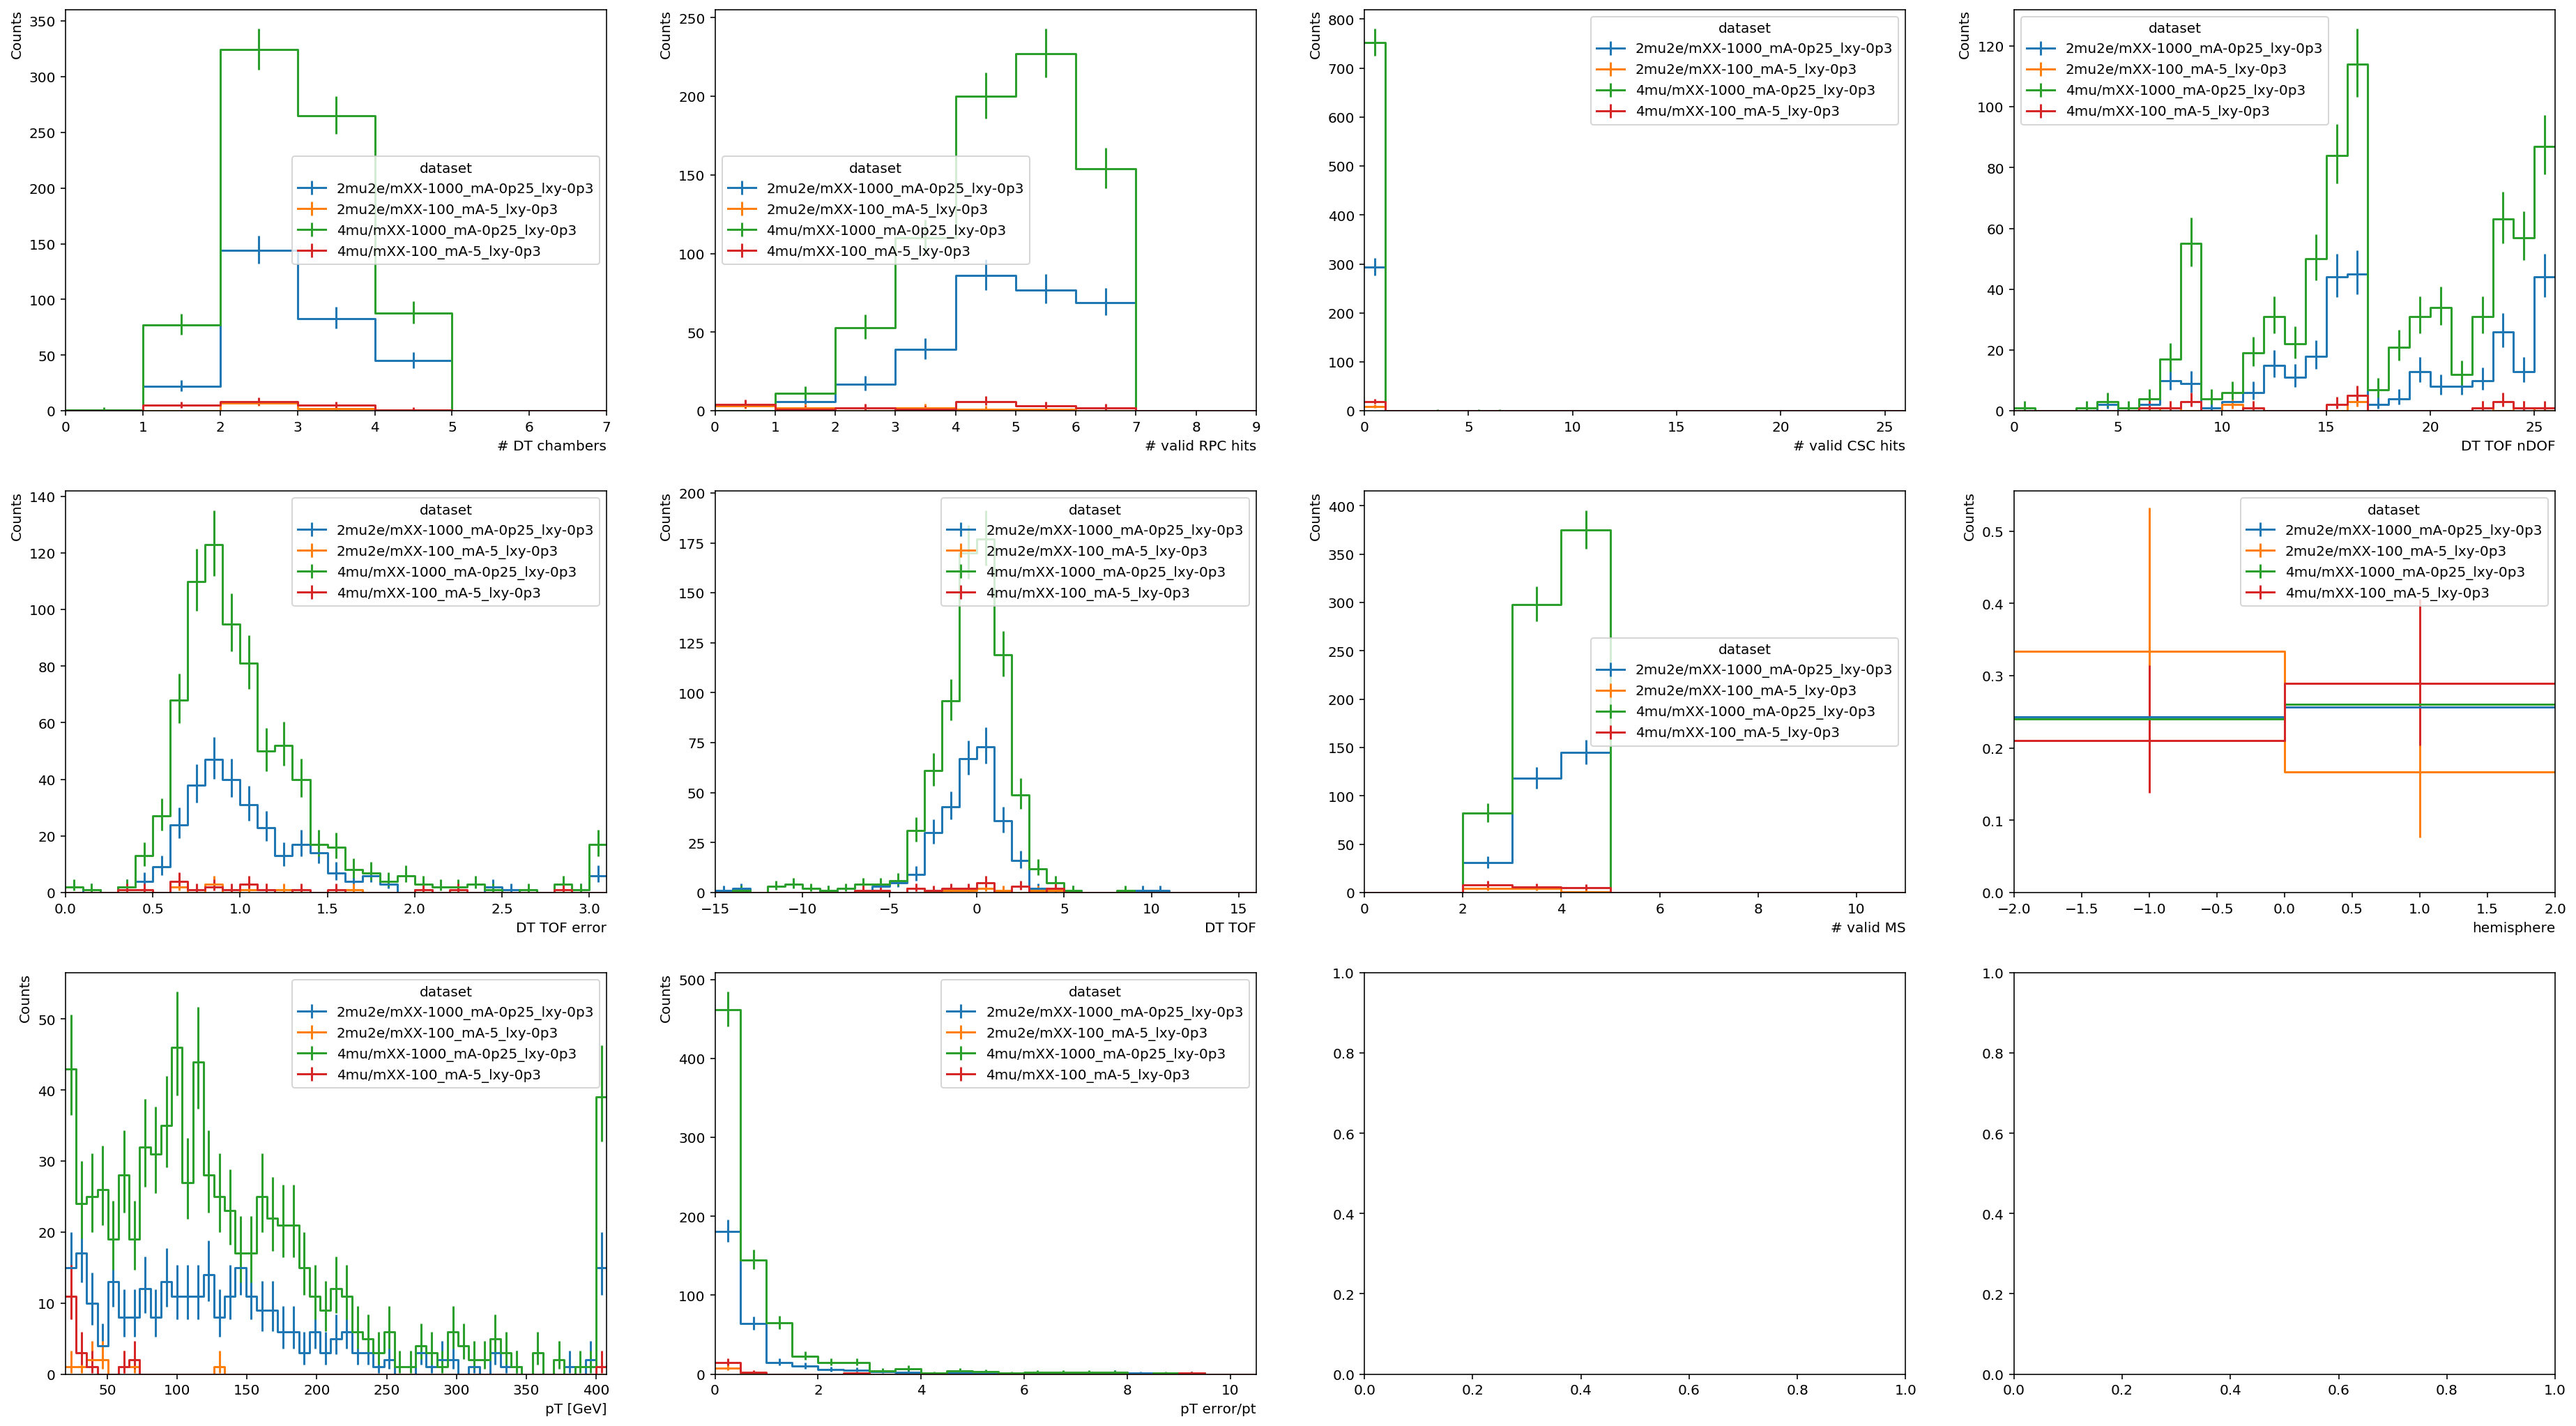

In [45]:
makeplot(cate=slice(0,1));

endcap

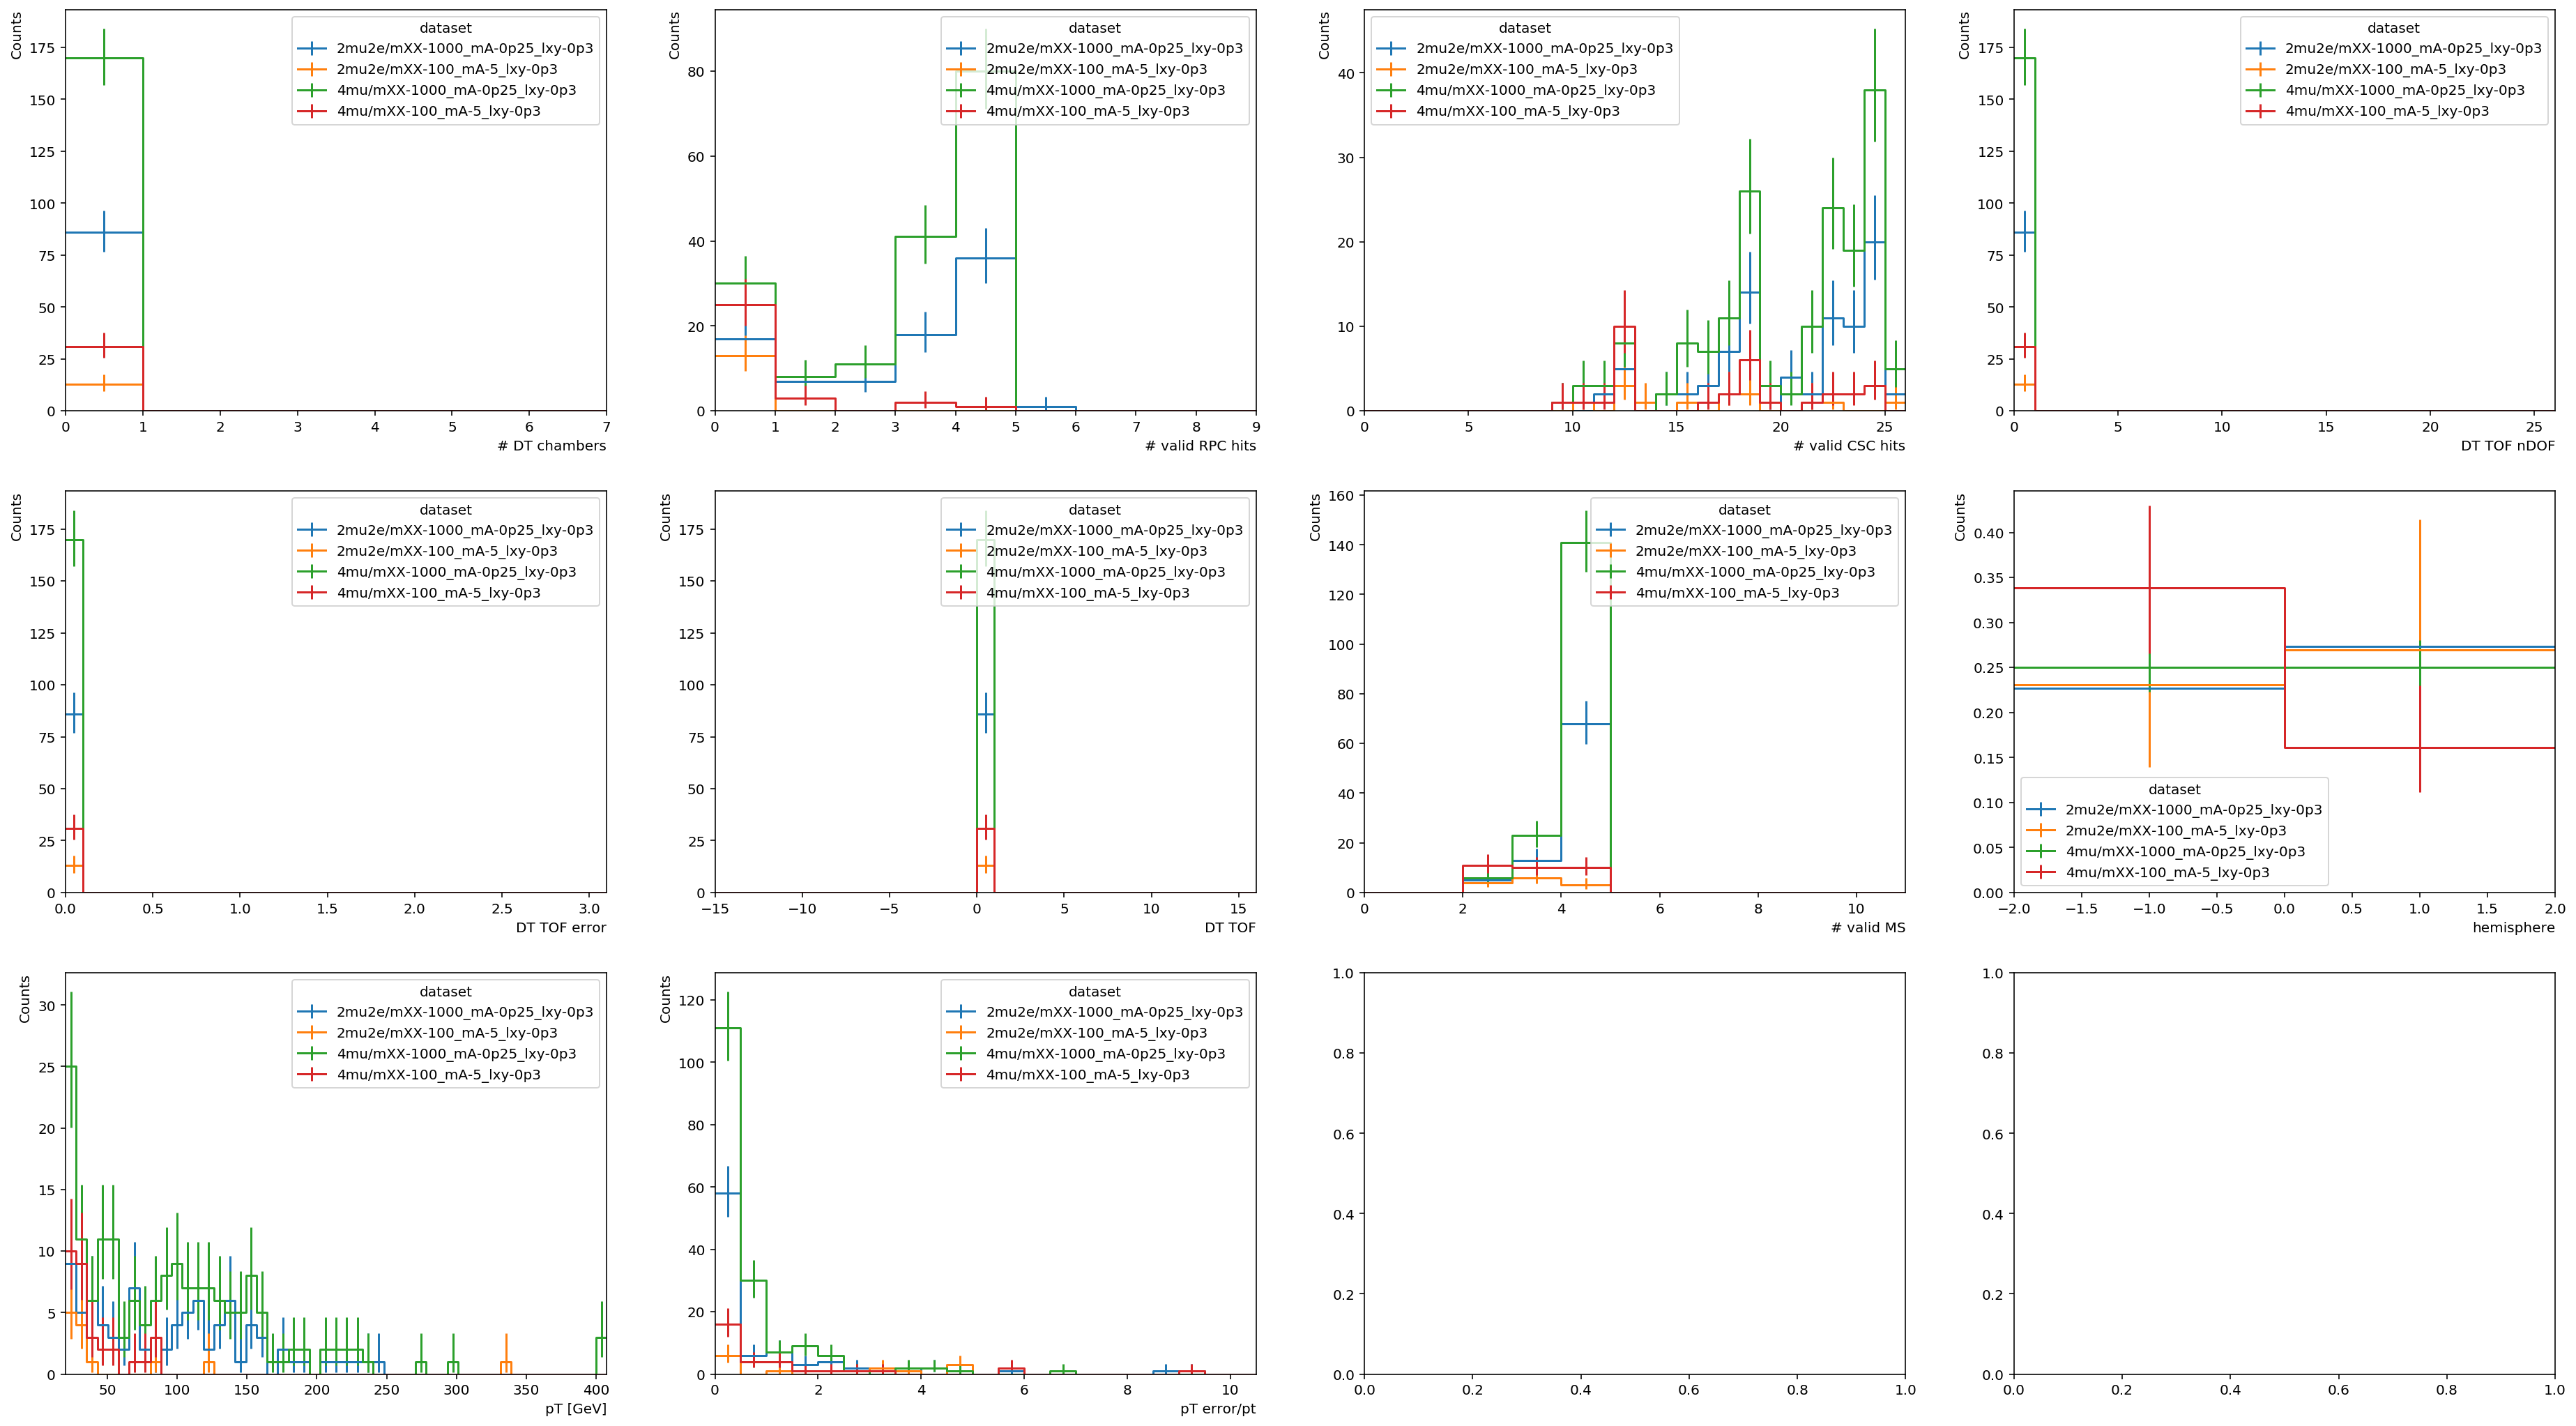

In [46]:
makeplot(cate=slice(2,3));

overlap

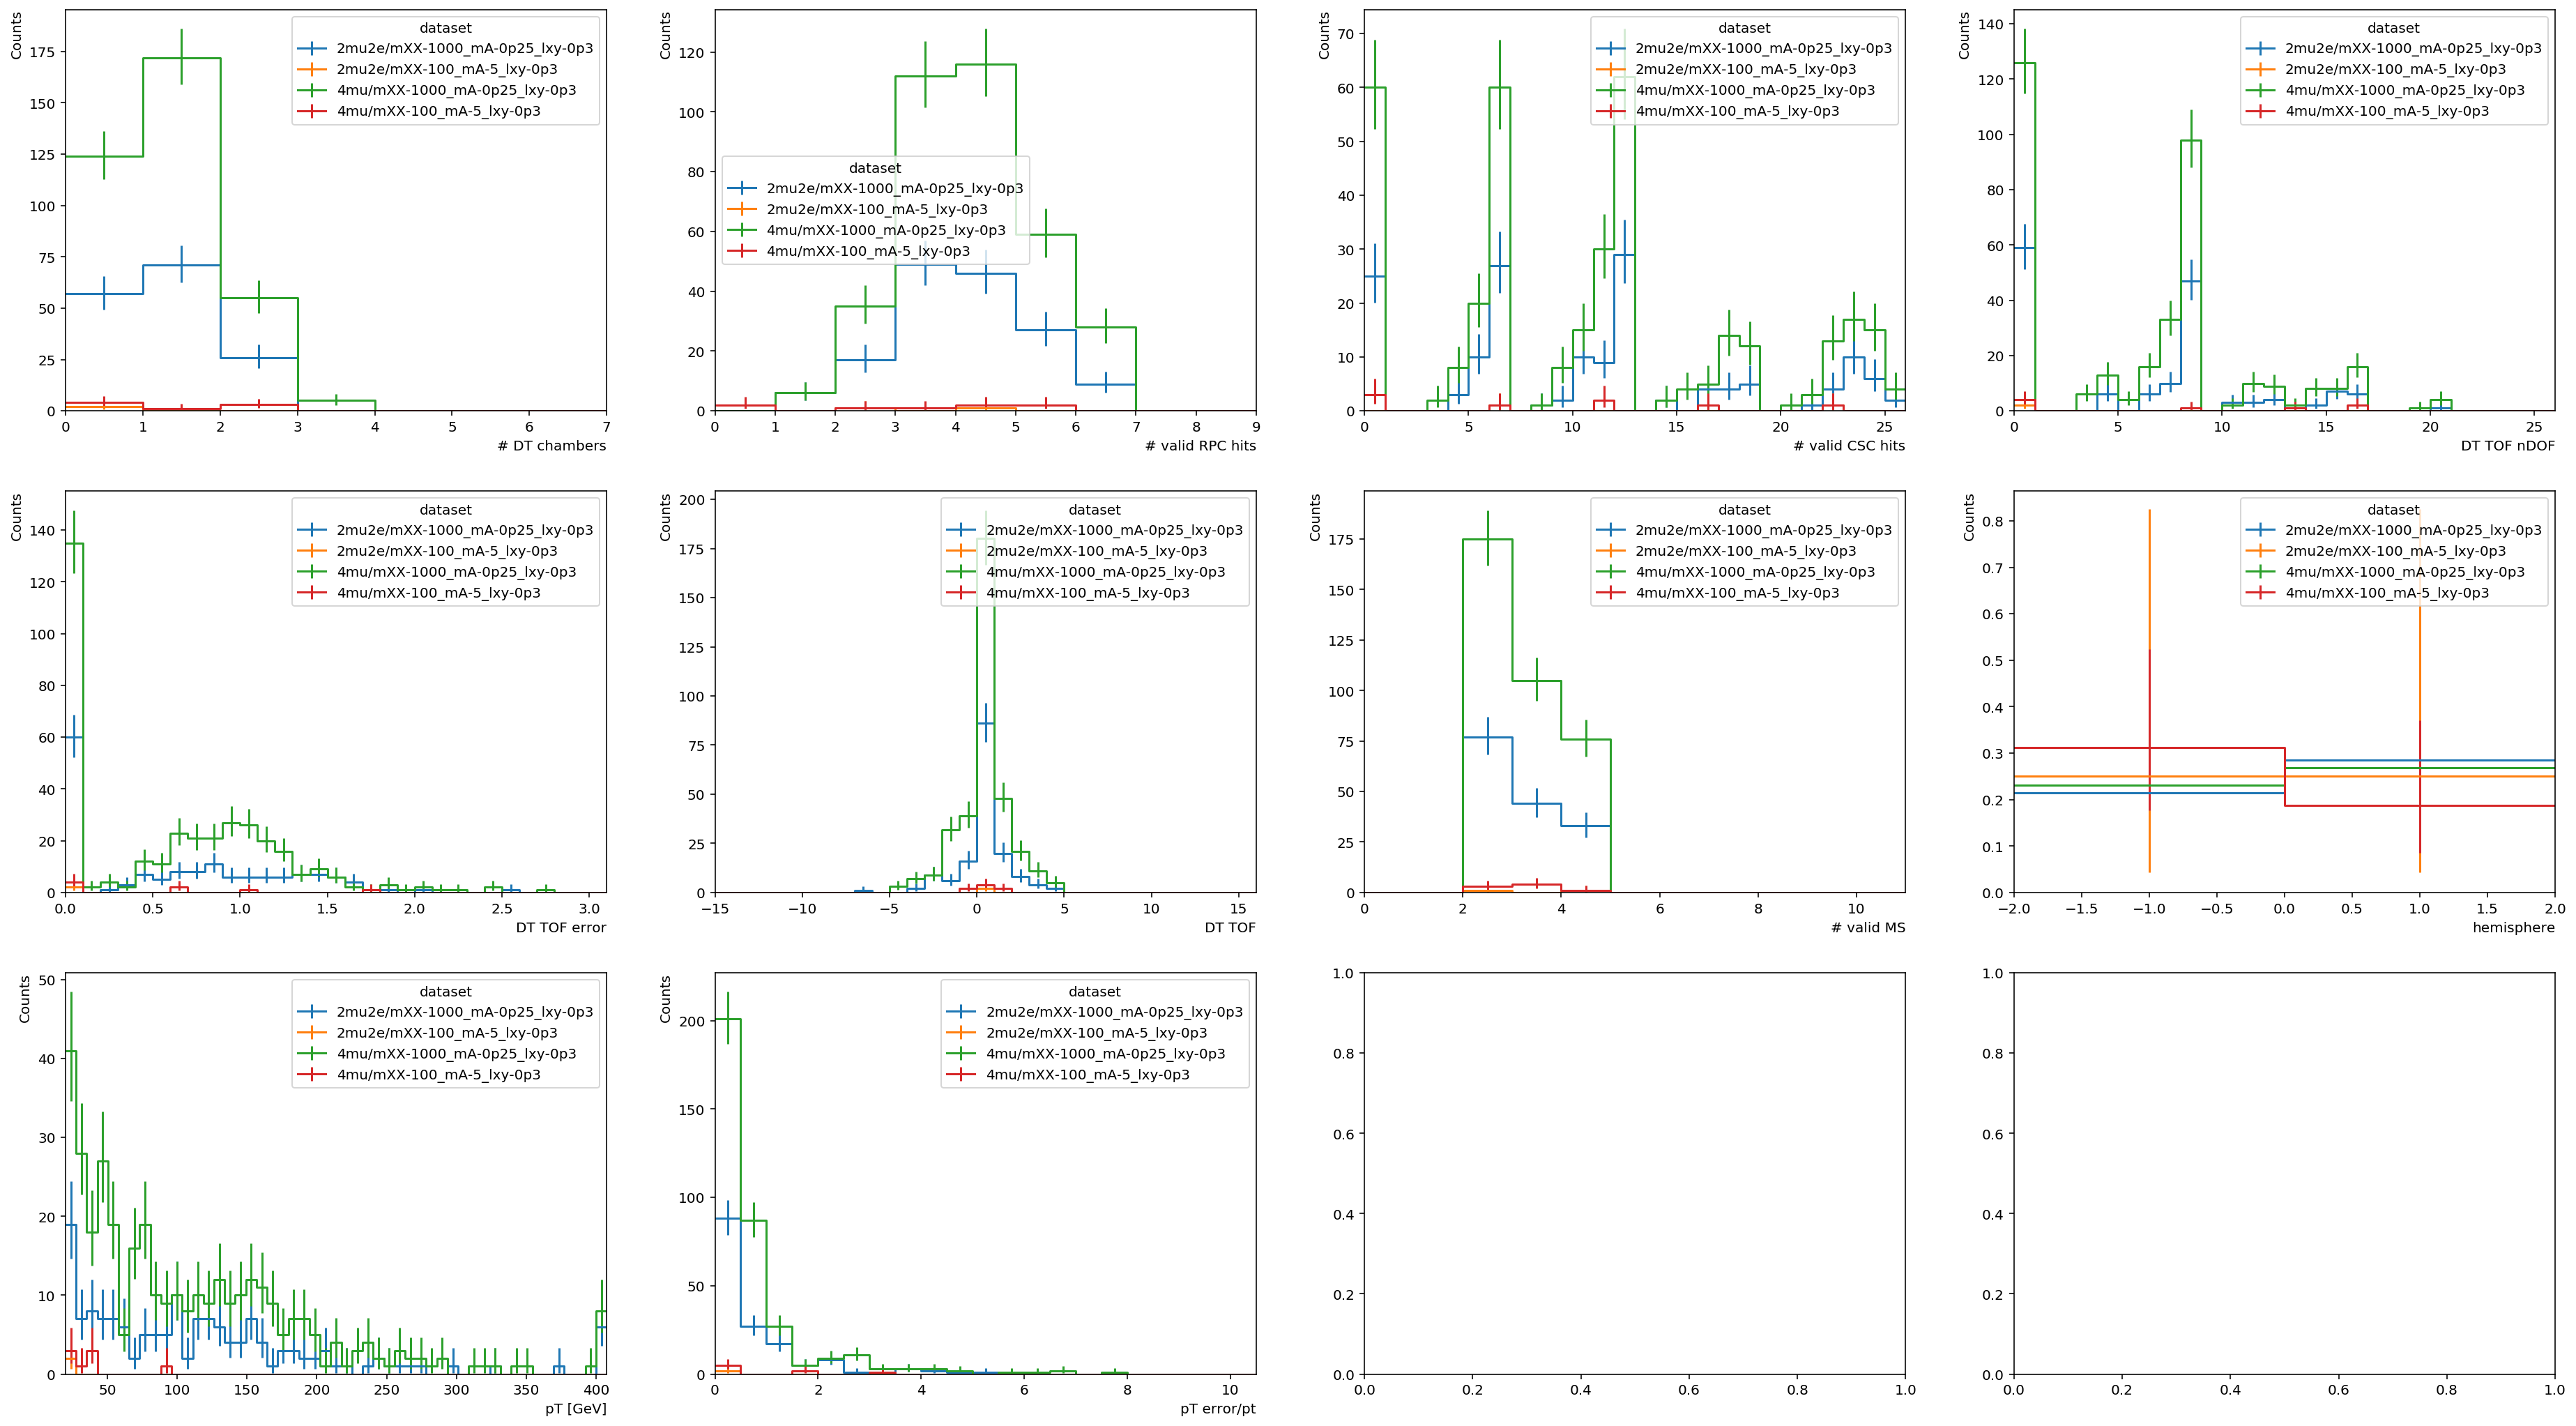

In [47]:
makeplot(cate=slice(1,2));

- lxy: 300cm

In [48]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaInLjProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  1.20items/s]


barrel

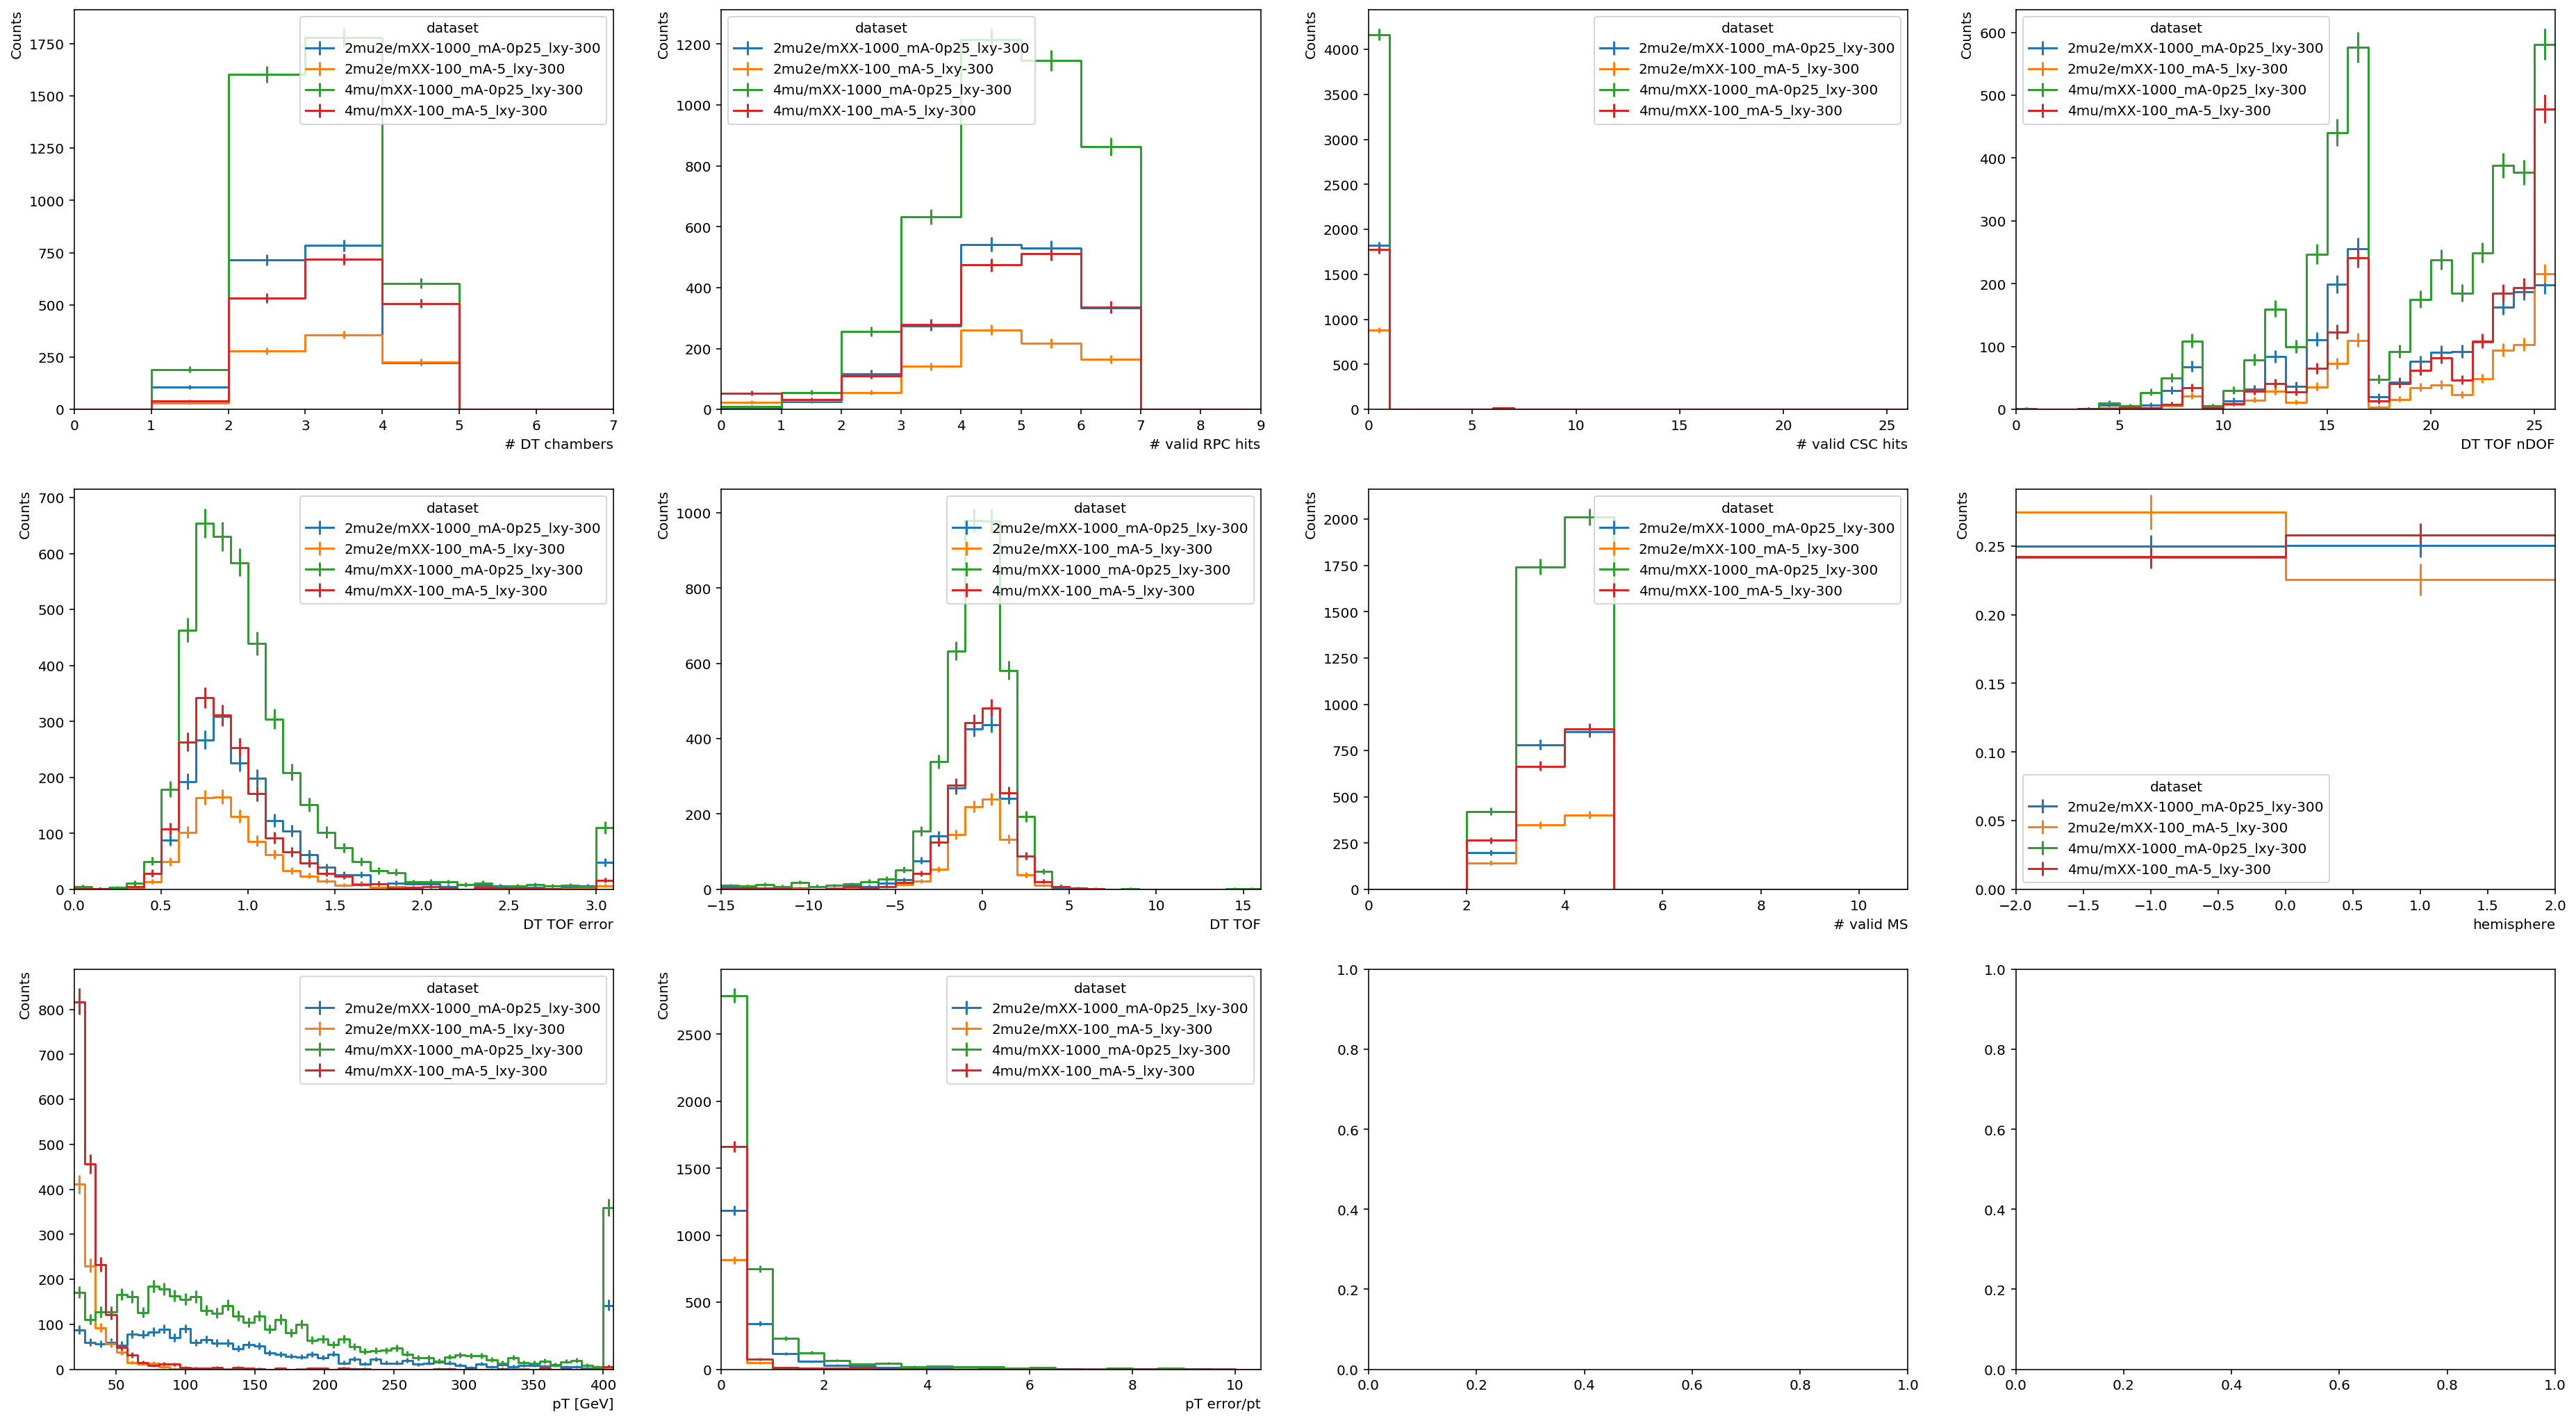

In [49]:
makeplot(cate=slice(0,1));

endcap

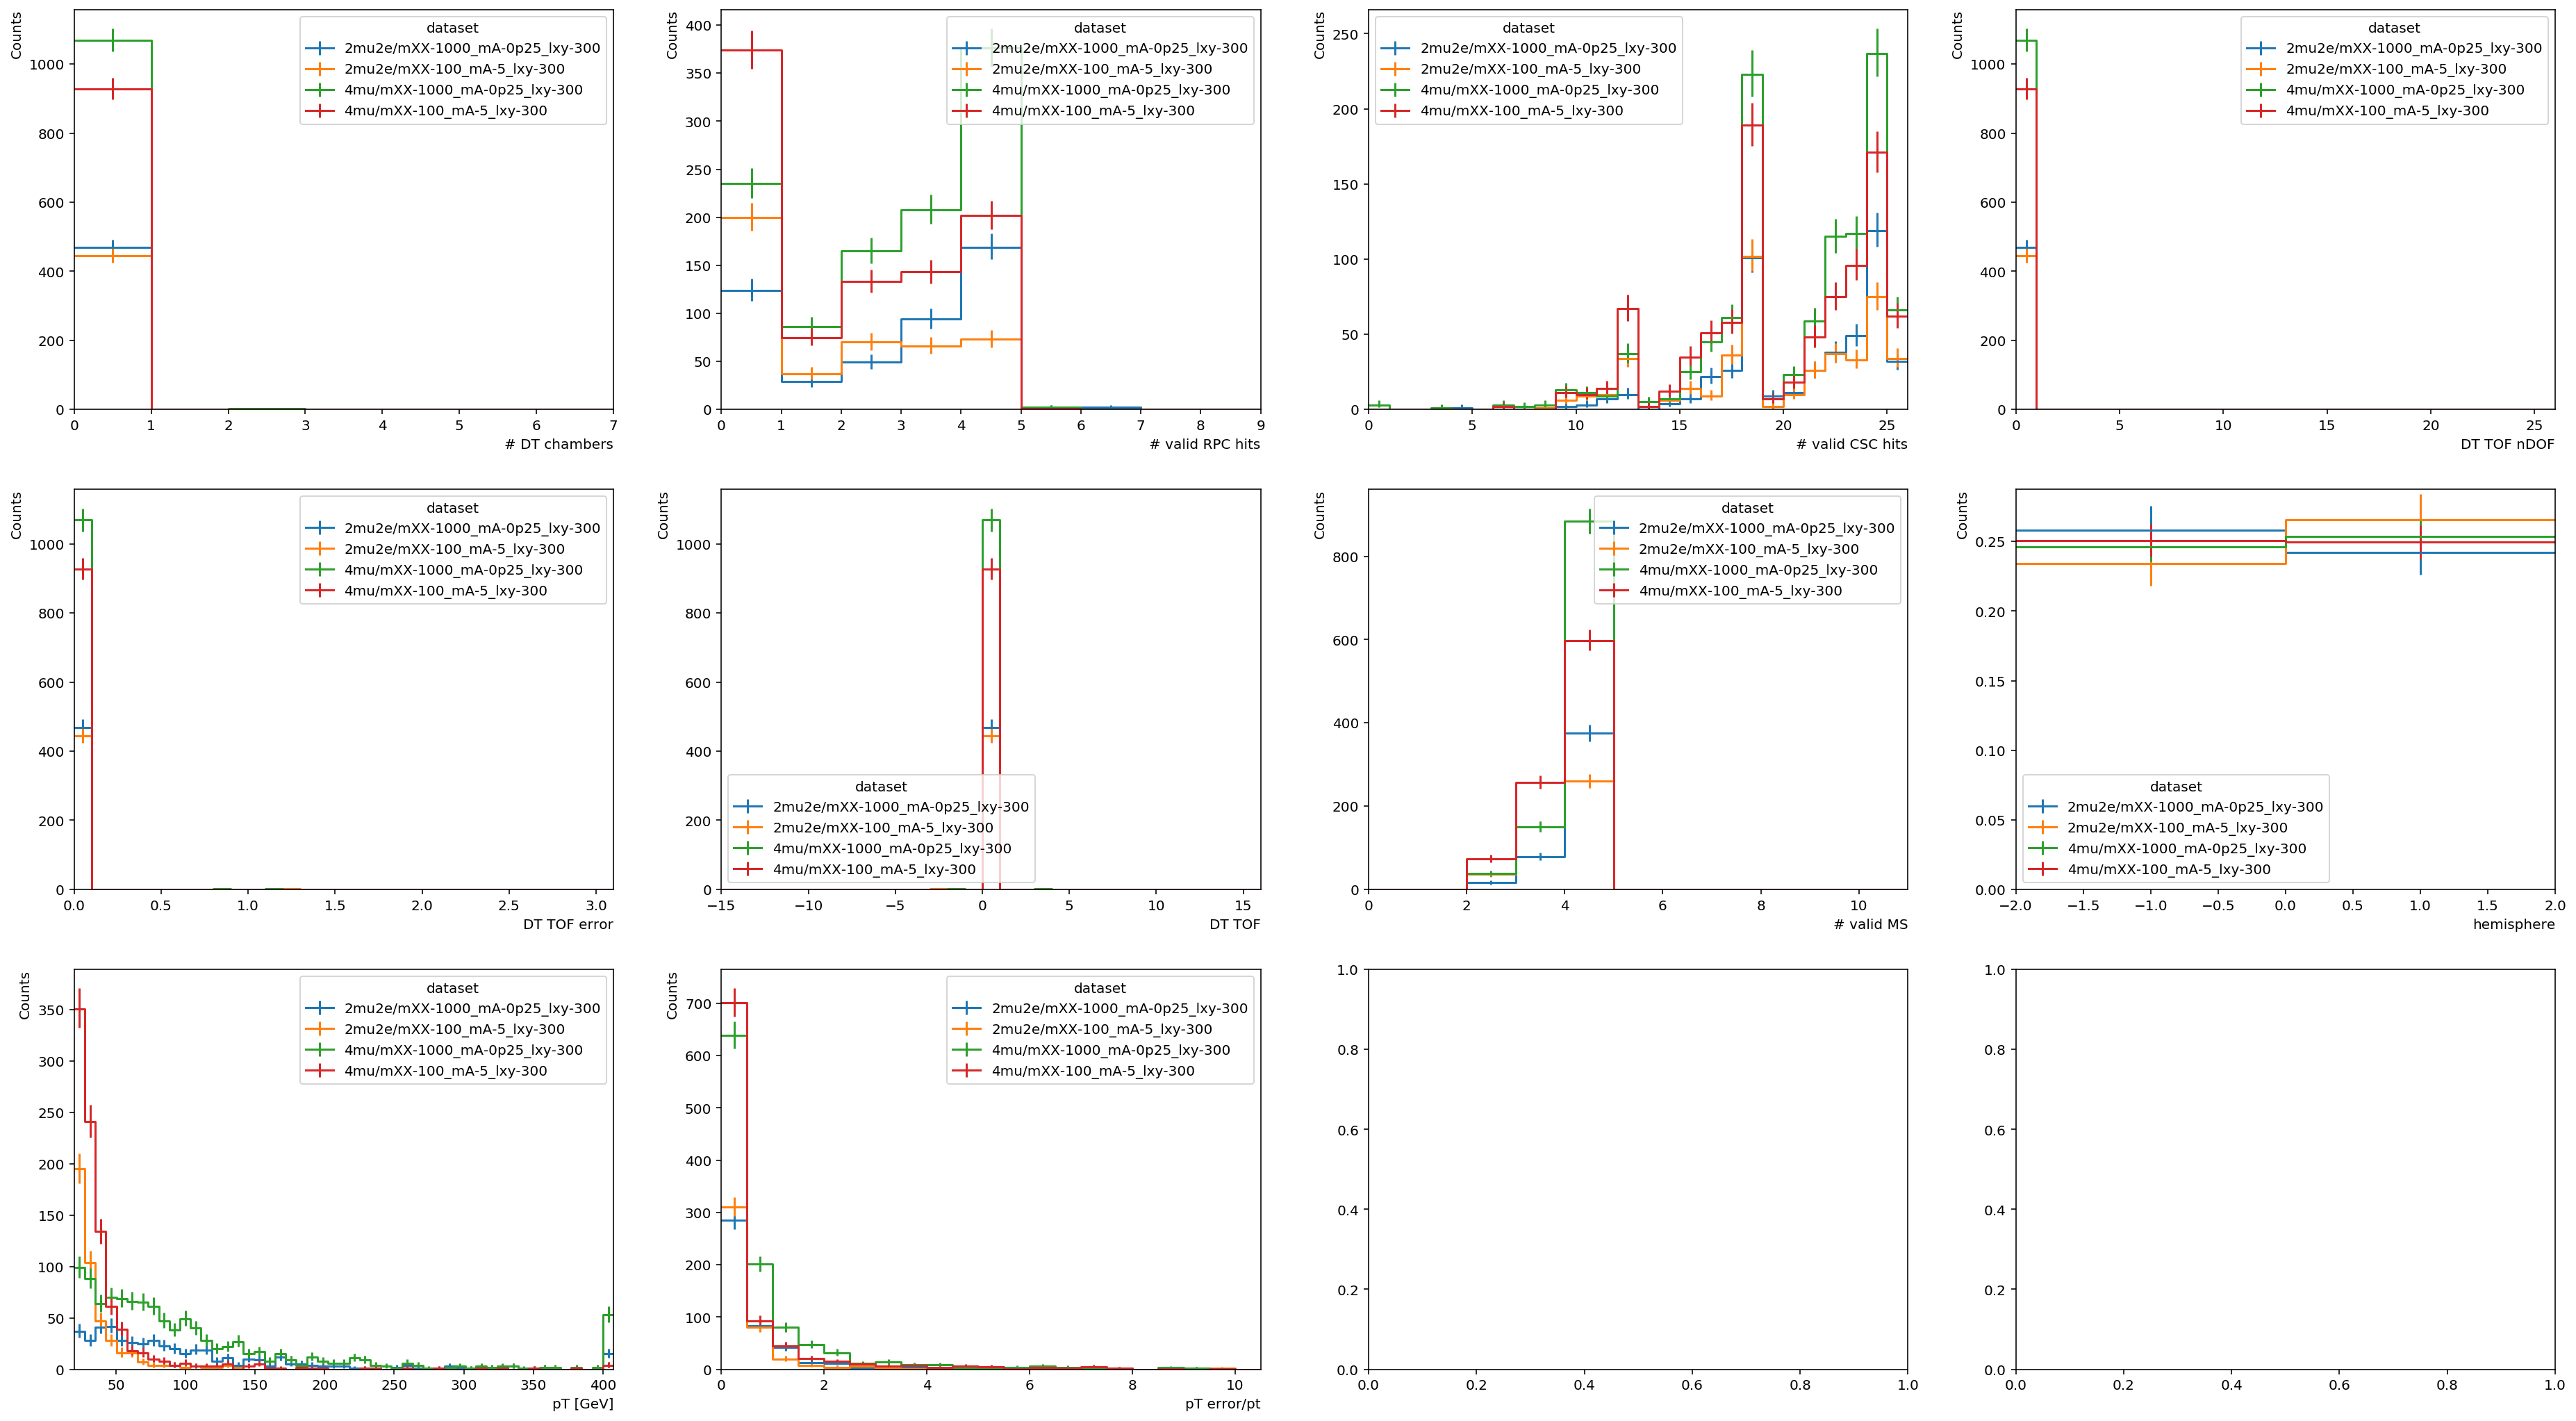

In [50]:
makeplot(cate=slice(2,3));

overlap

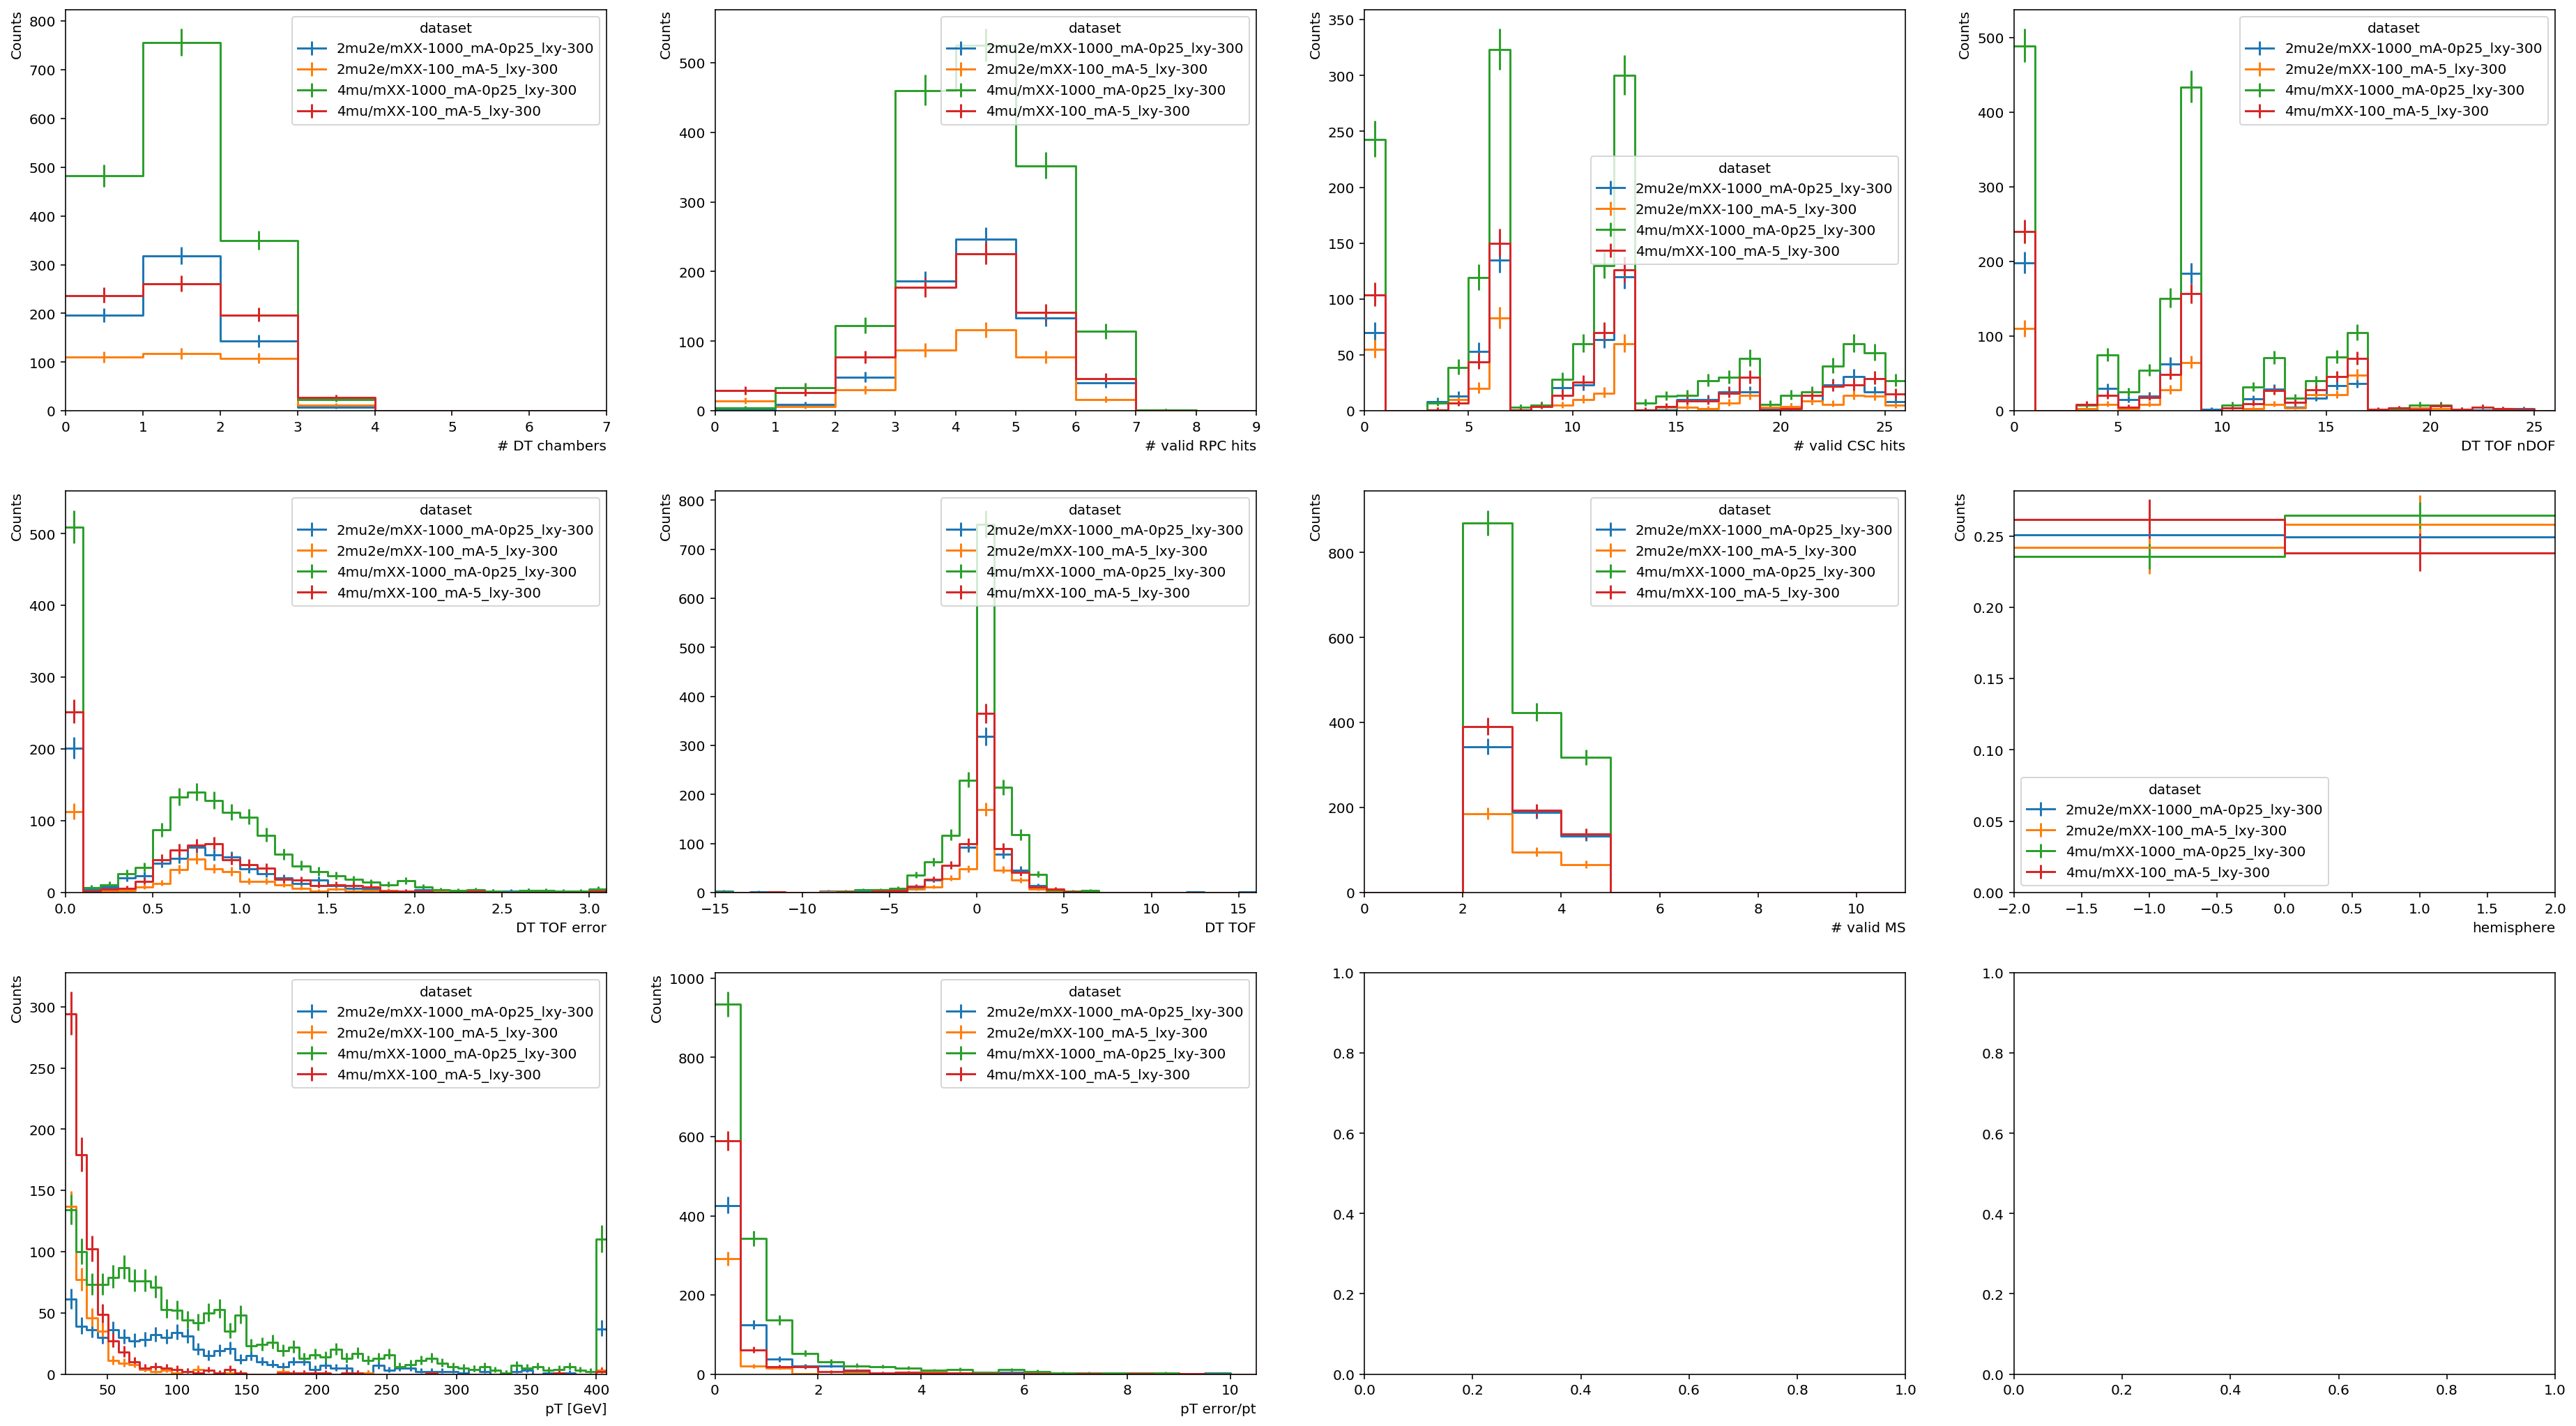

In [51]:
makeplot(cate=slice(1,2));

# on dSA quality cuts

In [59]:
class dsaCutsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        ptreso_axis = hist.Bin('ptreso', '$(p_T^{reco}-p_T^{gen})/p_T^{gen}$', 50, -1, 1)
        numhit_axis = hist.Bin('nhit', '# valid hits', 50, 0, 50)
        numsta_axis = hist.Bin('nsta', '# valid stations', 5, 0, 5)
        errpt_axis = hist.Bin('errpt', '$\sigma_{p_T}/p_T$', 20, 0, 5)
        qdiff_axis = hist.Bin('qdiff', '$q^{reco}-q^{gen}$', 5, -2, 3)
        self._accumulator = processor.dict_accumulator({
            'dsa': hist.Hist('Counts', dataset_axis, ptreso_axis, numhit_axis, numsta_axis, errpt_axis, qdiff_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            numhits=df['dsamuon_nValStaHits'],
            numstas=df['dsamuon_nStaValHits'],
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            charge=df['dsamuon_charge'],
        )
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            charge=df['gen_charge'],
        )
        genmuons = genparticles[np.abs(genparticles.pid)==13]
        
        crosspairs = dsamuons.cross(genmuons, nested=False)
        _distance = crosspairs.i0.p4.delta_r(crosspairs.i1.p4)
        _minidx = _distance.argmin()
        matchedpairs = crosspairs[_minidx][_distance[_minidx]<0.3].flatten()
        
        output['dsa'].fill(dataset=dataset,
                           ptreso=((matchedpairs.i0.p4.pt-matchedpairs.i1.p4.pt)/matchedpairs.i1.p4.pt).flatten(),
                           nhit=(matchedpairs.i0.cschits+matchedpairs.i0.dthits).flatten(),
                           nsta=(matchedpairs.i0.cscstas+matchedpairs.i0.dtstas).flatten(),
                           errpt=(matchedpairs.i0.pterr/matchedpairs.i0.p4.pt).flatten(),
                           qdiff=(matchedpairs.i0.charge-matchedpairs.i1.charge).flatten()
                          )
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [87]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

# dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
# }

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaCutsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.20items/s]


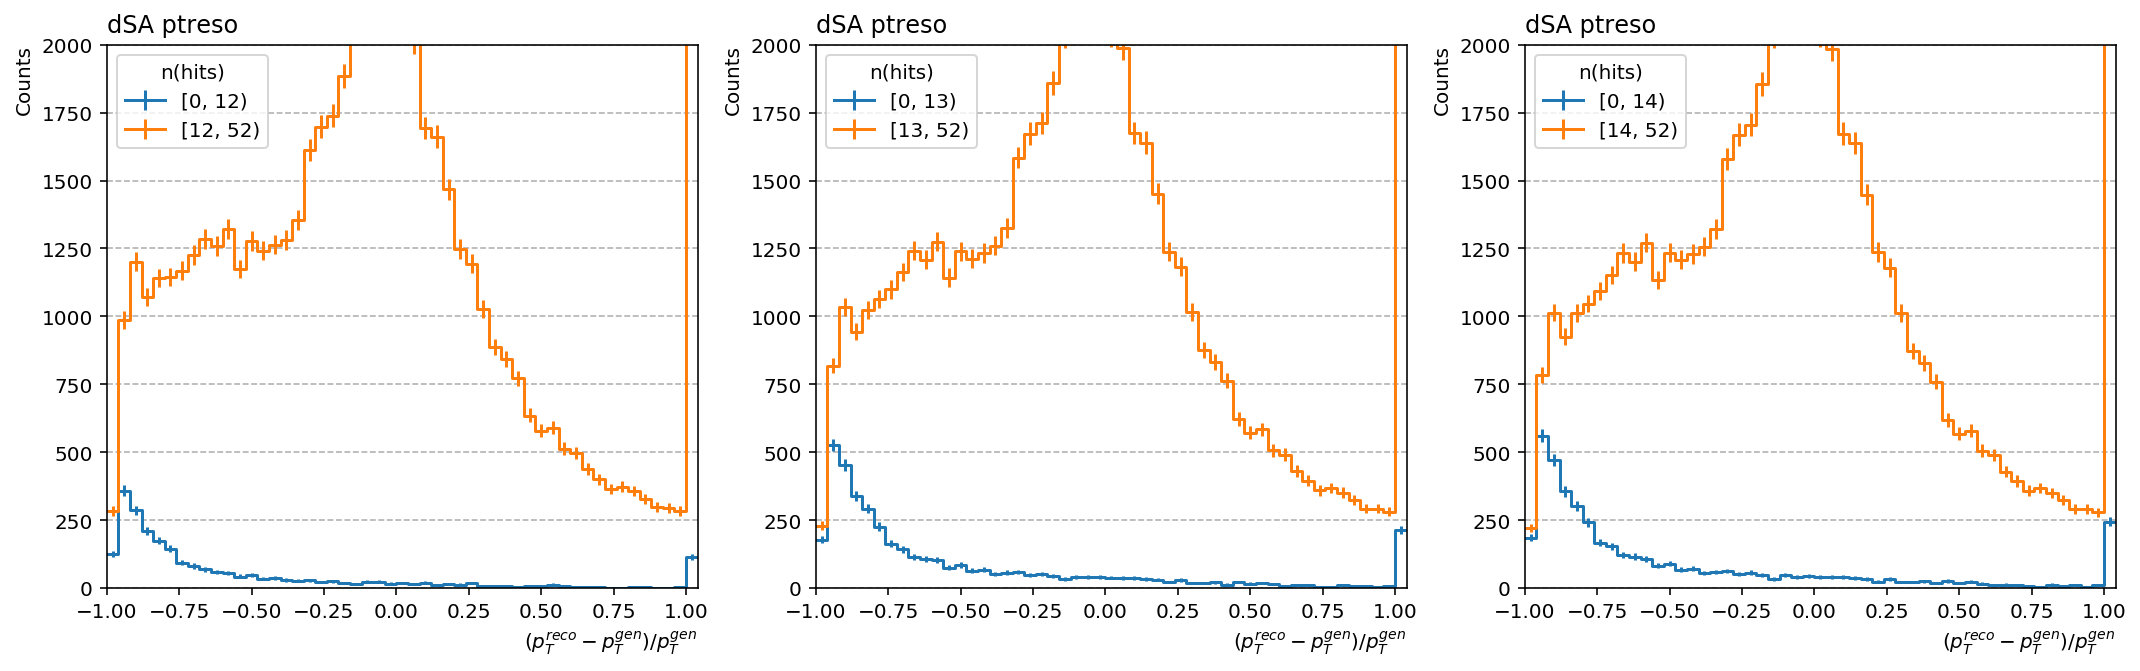

In [92]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nsta').integrate('qdiff').integrate('errpt')
metric = 13
h0 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric-1, 52]))
h1 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric, 52]))
h2 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric+1, 52]))
hist.plot1d(h0, overlay='nhit_', overflow='over', ax=axes[0], density=False)
hist.plot1d(h1, overlay='nhit_', overflow='over', ax=axes[1], density=False)
hist.plot1d(h2, overlay='nhit_', overflow='over', ax=axes[2], density=False)
for ax in axes.flat:
    ax.set_ylim([0, 2000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA ptreso', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

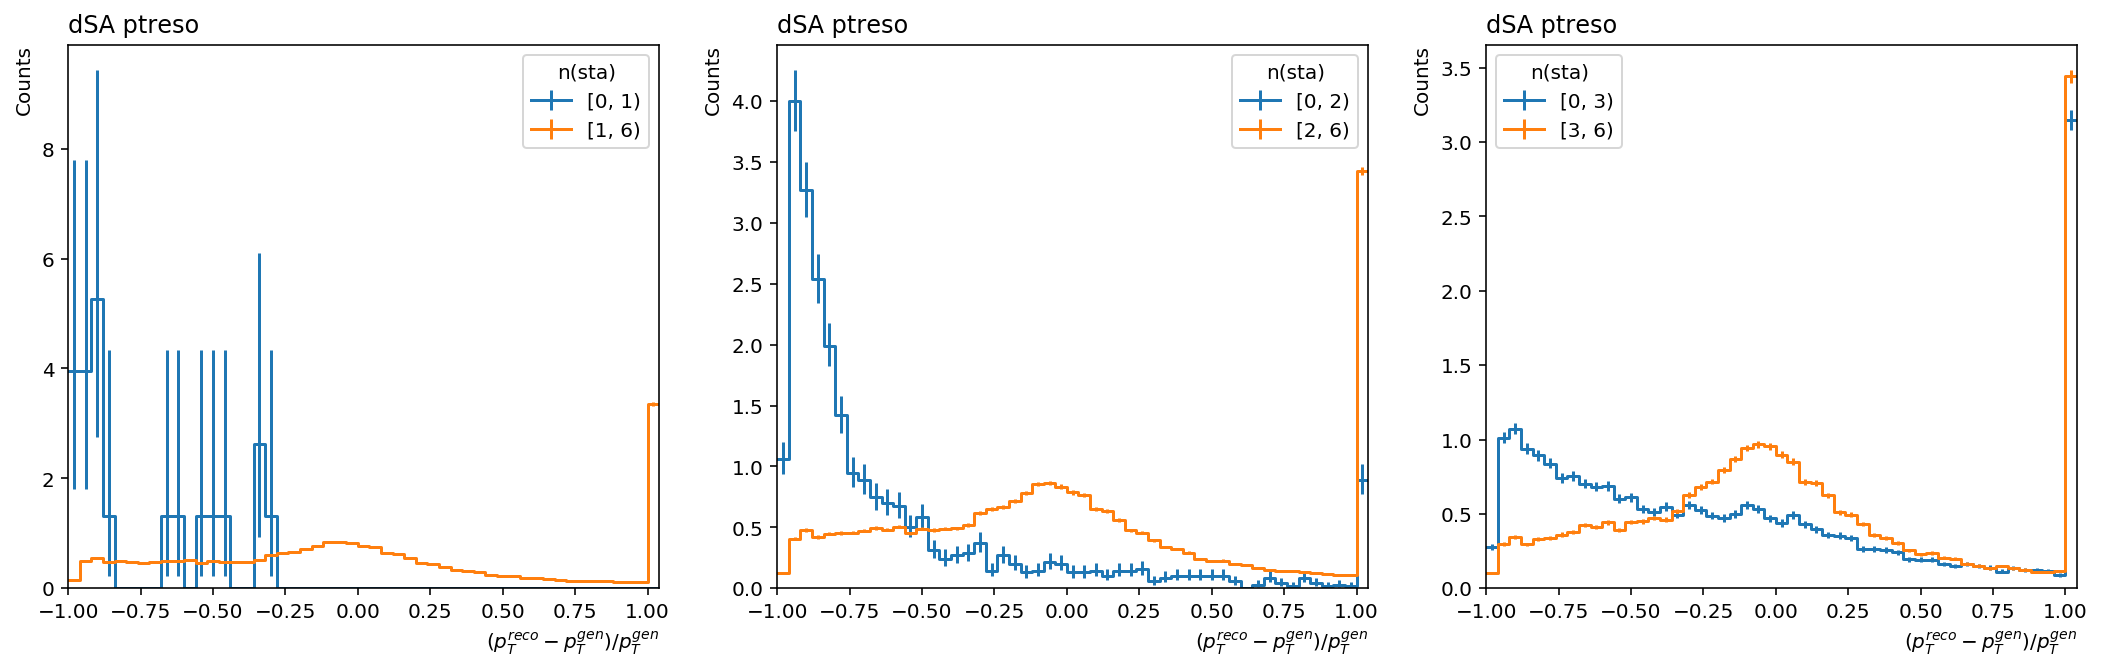

In [94]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('qdiff').integrate('errpt')
metric = 2
h0 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric-1, 6]))
h1 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric, 6]))
h2 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric+1, 6]))
hist.plot1d(h0, overlay='nsta_', overflow='over', ax=axes[0], density=True)
hist.plot1d(h1, overlay='nsta_', overflow='over', ax=axes[1], density=True)
hist.plot1d(h2, overlay='nsta_', overflow='over', ax=axes[2], density=True)
for ax in axes.flat:
    ax.set_title('dSA ptreso', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

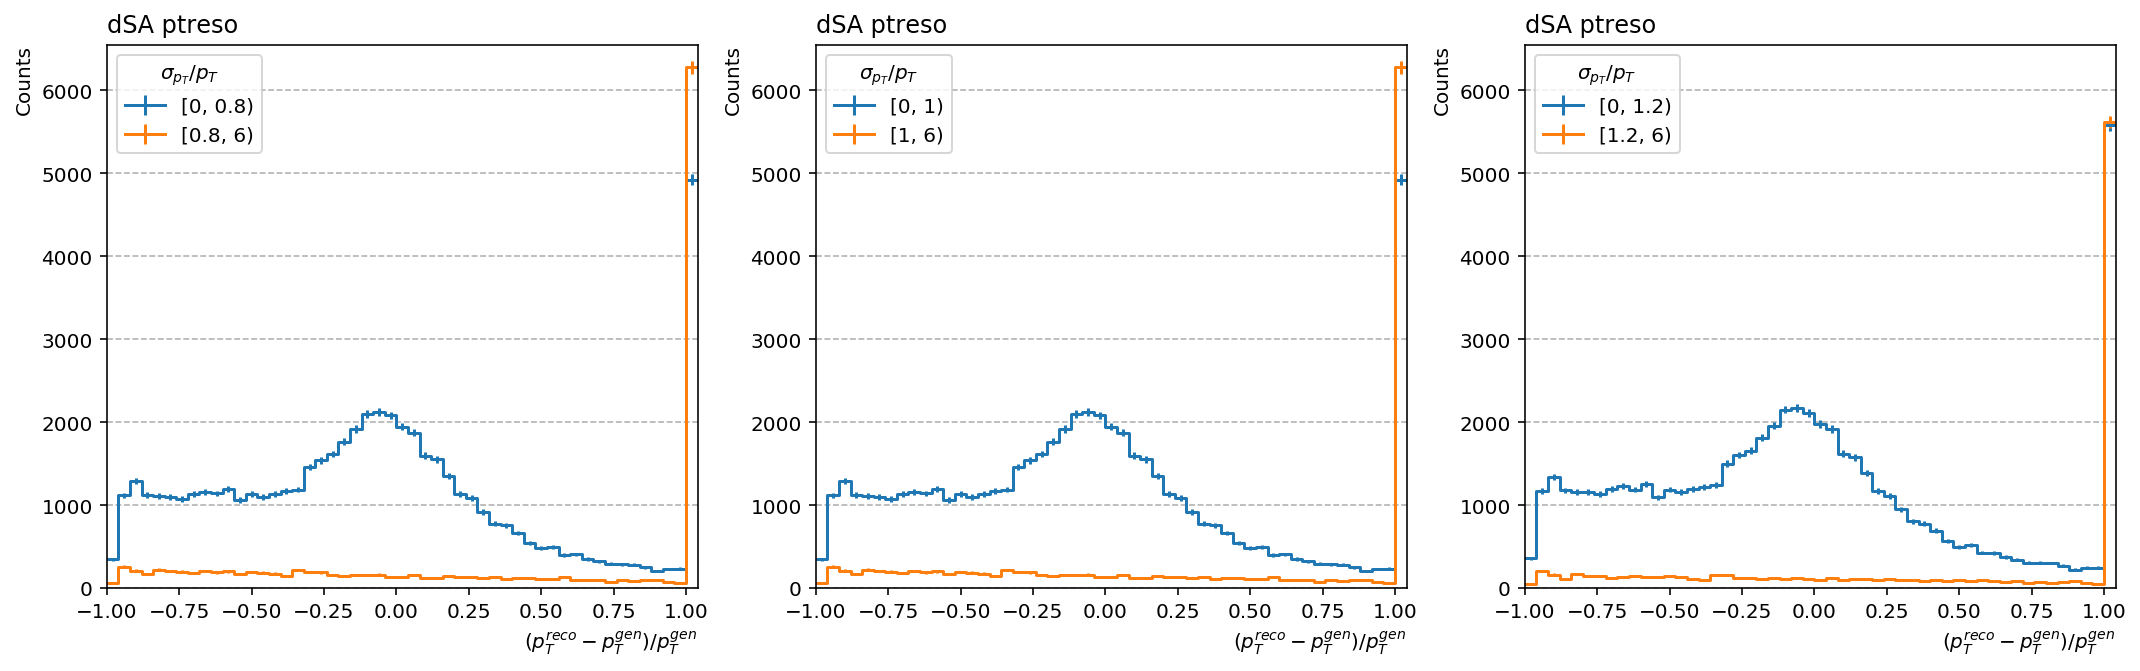

In [98]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('qdiff').integrate('nsta')
metric = 1.
h0 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric-0.2, 6]))
h1 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric,     6]))
h2 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric+0.2, 6]))
hist.plot1d(h0, overlay='errpt_', overflow='over', ax=axes[0], density=False)
hist.plot1d(h1, overlay='errpt_', overflow='over', ax=axes[1], density=False)
hist.plot1d(h2, overlay='errpt_', overflow='over', ax=axes[2], density=False)
for ax in axes.flat:
    ax.set_ylim([0, 6550])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA ptreso', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

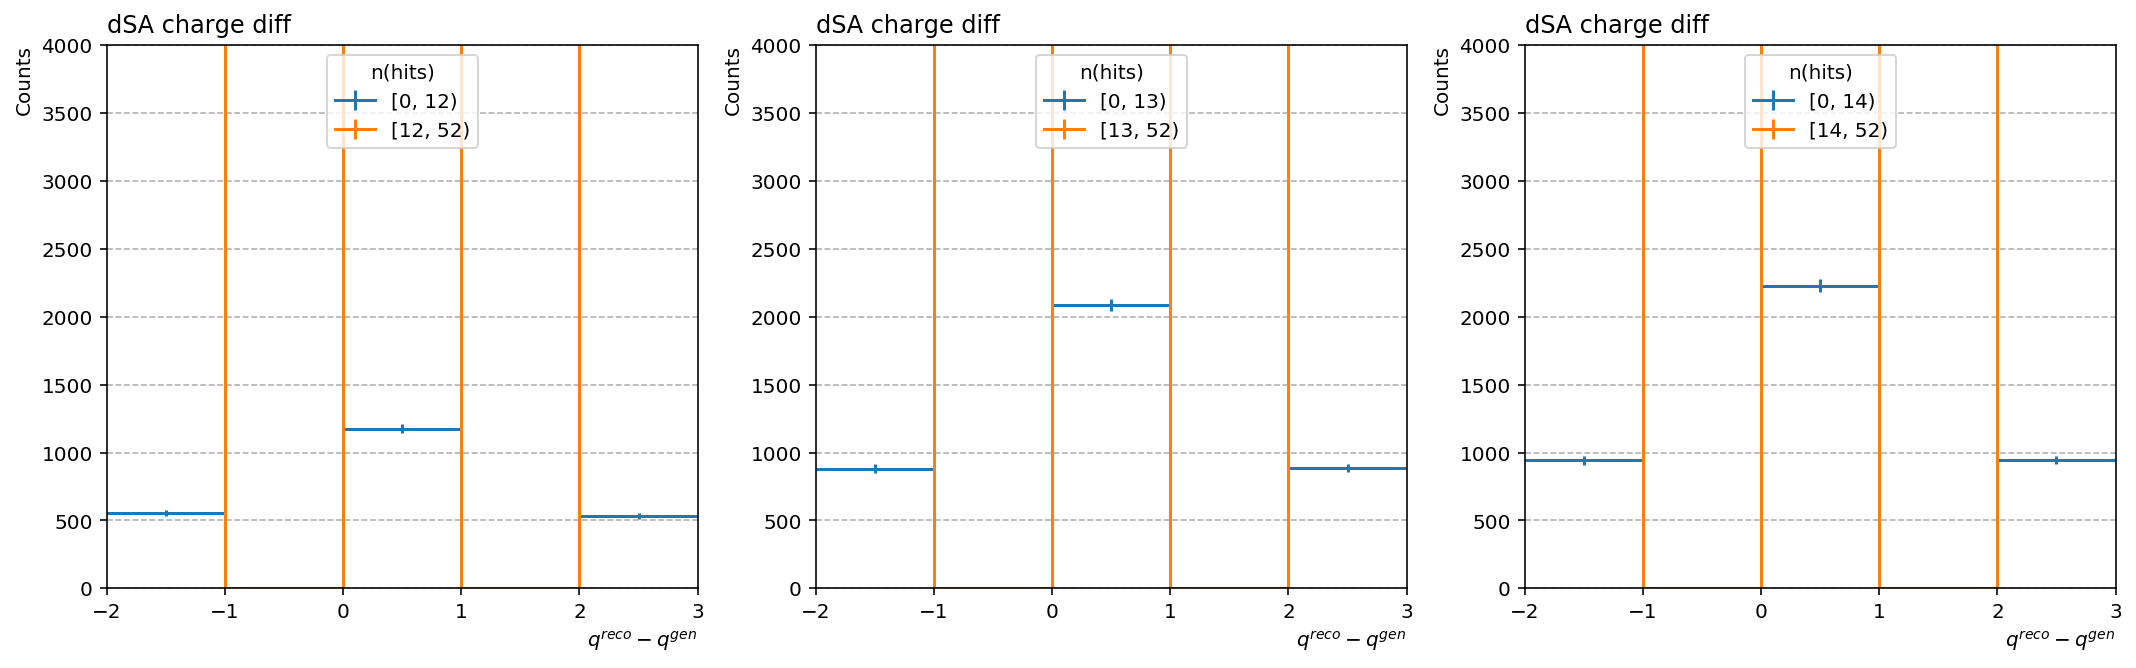

In [93]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nsta').integrate('ptreso').integrate('errpt')
metric = 13
h0 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric-1, 52]))
h1 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric, 52]))
h2 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric+1, 52]))
hist.plot1d(h0, overlay='nhit_', ax=axes[0], density=False)
hist.plot1d(h1, overlay='nhit_', ax=axes[1], density=False)
hist.plot1d(h2, overlay='nhit_', ax=axes[2], density=False)
for ax in axes.flat:
    ax.set_ylim([0, 4000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA charge diff', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

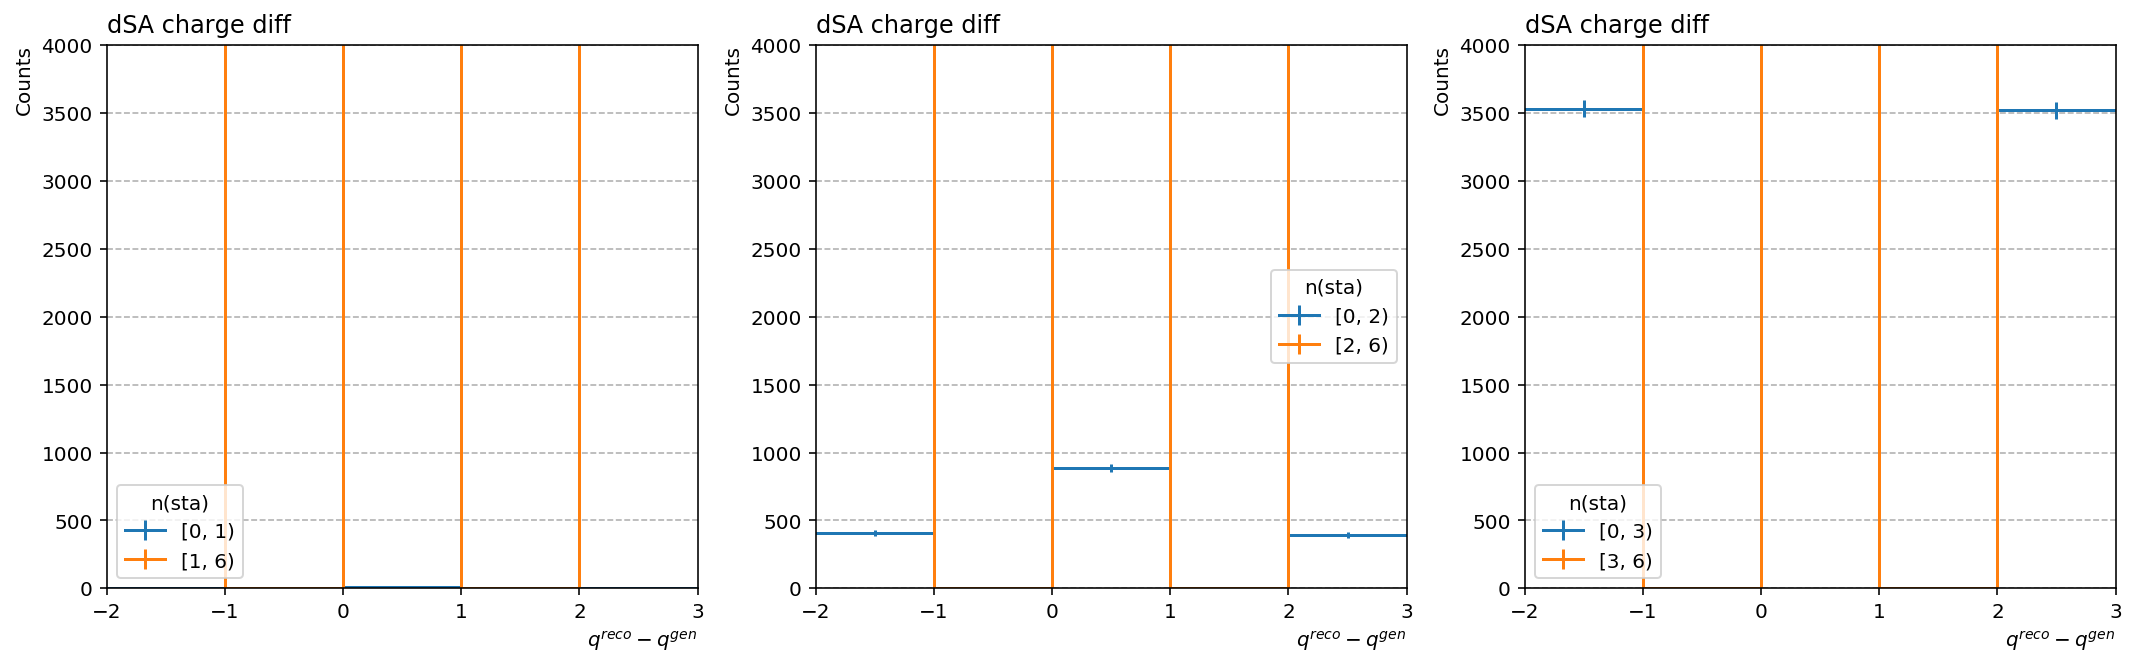

In [95]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('ptreso').integrate('errpt')
metric = 2
h0 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric-1, 6]))
h1 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric, 6]))
h2 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric+1, 6]))
hist.plot1d(h0, overlay='nsta_', ax=axes[0], density=False)
hist.plot1d(h1, overlay='nsta_', ax=axes[1], density=False)
hist.plot1d(h2, overlay='nsta_', ax=axes[2], density=False)
for ax in axes.flat:
    ax.set_ylim([0, 4000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA charge diff', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

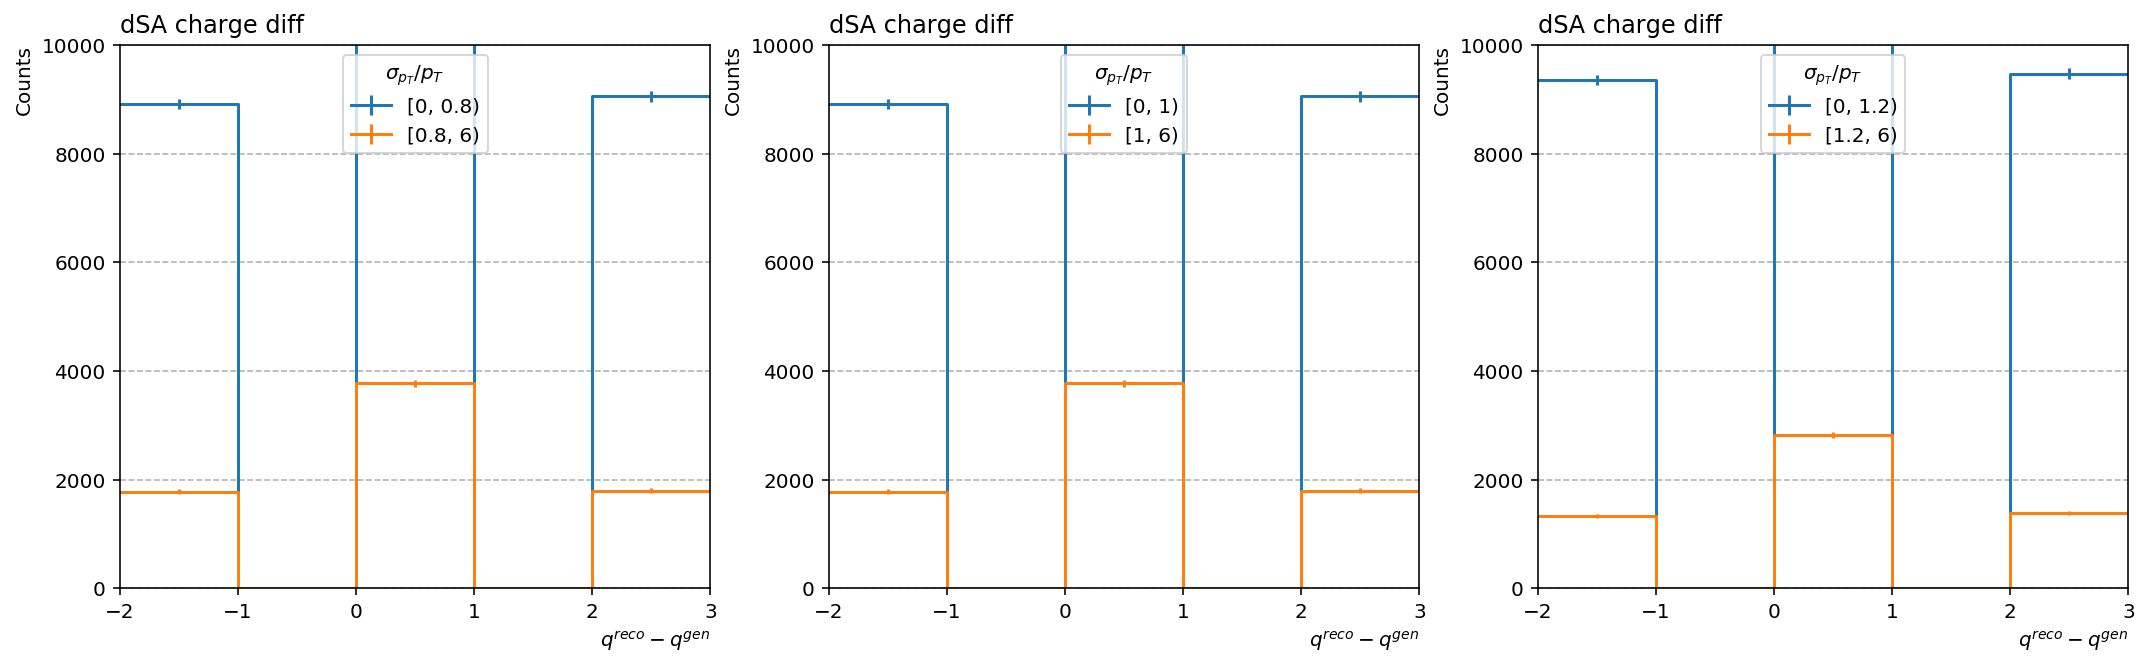

In [100]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('ptreso').integrate('nsta')
metric = 1.
h0 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric-0.2, 6]))
h1 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric,     6]))
h2 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric+0.2, 6]))
hist.plot1d(h0, overlay='errpt_', overflow='none', ax=axes[0], density=False)
hist.plot1d(h1, overlay='errpt_', overflow='none', ax=axes[1], density=False)
hist.plot1d(h2, overlay='errpt_', overflow='none', ax=axes[2], density=False)
for ax in axes.flat:
    ax.set_ylim([0, 10000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA charge diff', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");